In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from numpy import mean
from numpy import std
from sklearn.preprocessing import LabelEncoder as le
from scipy import stats
%matplotlib inline
plt.rcParams['agg.path.chunksize'] = 100000

In [93]:
np.random.seed(7)

In [94]:
location_datasetdir = '../datasets/location_dataset/'
figuredir = '../figures/acw_location/'
datasetdir = '../datasets/new_location_dataset/'

import os

CHECK_FOLDER = os.path.isdir(datasetdir)

if not CHECK_FOLDER:
    os.makedirs(datasetdir)
    print("Created folder : ", datasetdir)
else:
    print(datasetdir, "Folder already exists")
    
CHECK_FOLDER = os.path.isdir(figuredir)

if not CHECK_FOLDER:
    os.makedirs(figuredir)
    print("Created folder : ", figuredir)
else:
    print(figuredir, "Folder already exists")

../datasets/new_location_dataset/ Folder already exists
../figures/acw_location/ Folder already exists


In [95]:
dataset = "location-dataset.txt"
data = pd.read_csv(location_datasetdir + dataset)
data.info(), data.head(), data.shape

#General parameters:
trainingSize = 75
lookBack = 25

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3530 entries, 0 to 3529
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   location  3530 non-null   float64
dtypes: float64(1)
memory usage: 27.7 KB


In [96]:
datasetNoise = "location-dataset-noise.txt"
mu, sigma = 0, 0.1
noise = np.random.normal(mu, sigma, [data.shape[0], data.shape[1]])
signal = data + noise
signal.to_csv(datasetdir + datasetNoise, index=False)

dataNoise = pd.read_csv(datasetdir + datasetNoise)

In [97]:
def finding_outliers(dataset):
    #Find the respective z-score for all values in the dataset
    dataset['z_score'] = stats.zscore(dataset['location'])

    #Any absolute value of z-score above 0.1 is an outlier
    dataset.loc[dataset['z_score'].abs() <= 0.1]

    return dataset

In [98]:
def configure_parameters(b, e, o, n, u):
    #Hyper parameters:
    batchSize = b
    epochs = e
    optimizer = o
    neurons = n
    unit = u

    return batchSize, epochs, optimizer, neurons, unit

In [99]:
def configure_parameters2(b, e, o, n1, n2, u):
    #Hyper parameters:
    batchSize = b
    epochs = e
    optimizer = o
    neurons1 = n1
    neurons2 = n2
    unit = u

    return batchSize, epochs, optimizer, neurons1, neurons2, unit

In [100]:
def configure_parameters3(b, e, o, n1, n2, n3, u):
    #Hyper parameters:
    batchSize = b
    epochs = e
    optimizer = o
    neurons1 = n1
    neurons2 = n2
    neurons3 = n3
    unit = u

    return batchSize, epochs, optimizer, neurons1, neurons2, neurons3, unit

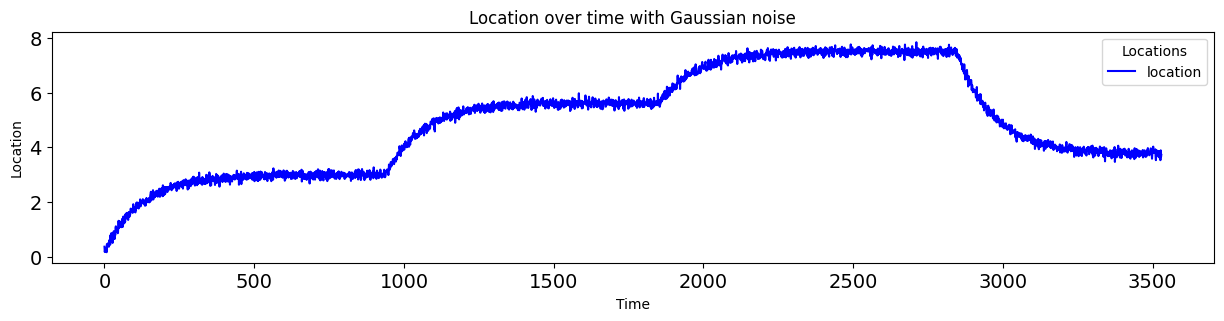

In [101]:
dataNoise['location'].plot(color='b', figsize=(15,3))
plt.legend(loc=2)
plt.xlabel("Time")
plt.ylabel("Location")
plt.title('Location over time with Gaussian noise')
plt.tick_params(axis='both',labelsize=14)
plt.legend(loc='upper right')
plt.legend(title="Locations")
plt.savefig(figuredir + "location-over-time-with-noise.png", bbox_inches='tight', dpi=1200)

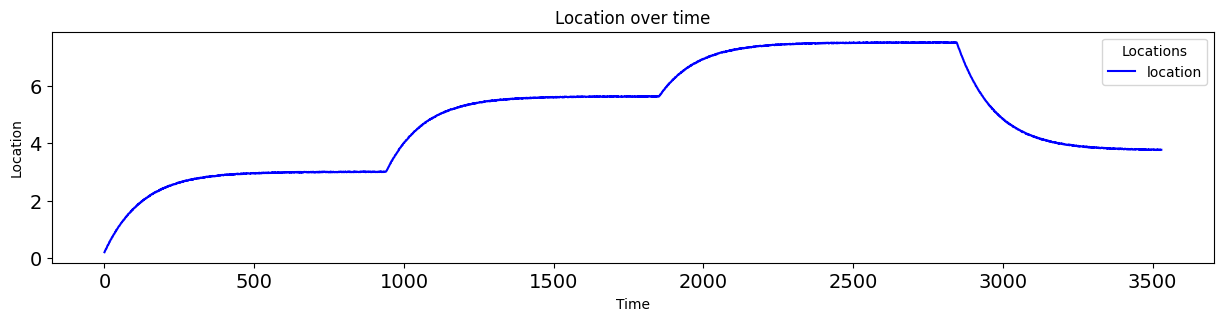

In [102]:
data['location'].plot(color='b', figsize=(15,3))
plt.legend(loc=2)
plt.xlabel("Time")
plt.ylabel("Location")
plt.title('Location over time')
plt.tick_params(axis='both',labelsize=14)
plt.legend(loc='upper right')
plt.legend(title="Locations")
plt.savefig(figuredir + "location-over-time.png", bbox_inches='tight', dpi=1200)

In [103]:
location = data['location']
location = pd.DataFrame(location)
location.info()

locationNoise = dataNoise['location']
locationNoise = pd.DataFrame(locationNoise)
locationNoise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3530 entries, 0 to 3529
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   location  3530 non-null   float64
dtypes: float64(1)
memory usage: 27.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3530 entries, 0 to 3529
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   location  3530 non-null   float64
dtypes: float64(1)
memory usage: 27.7 KB


In [104]:
df = location
df

dfNoise = locationNoise
dfNoise

,location
0,0.369053
1,0.175806
2,0.257903
3,0.307415
4,0.219638
...,...
3525,3.792344
3526,3.530716
3527,3.890261
3528,3.649004


In [105]:
df = finding_outliers(df)
df

dfNoise = finding_outliers(dfNoise)
dfNoise

,location,z_score
0,0.369053,-2.477839
1,0.175806,-2.582087
2,0.257903,-2.537800
3,0.307415,-2.511090
4,0.219638,-2.558442
...,...,...
3525,3.792344,-0.631132
3526,3.530716,-0.772268
3527,3.890261,-0.578310
3528,3.649004,-0.708457


In [106]:
df = df['location']
df = pd.DataFrame(df)
df

dfNoise = dfNoise['location']
dfNoise = pd.DataFrame(dfNoise)
dfNoise

,location
0,0.369053
1,0.175806
2,0.257903
3,0.307415
4,0.219638
...,...
3525,3.792344
3526,3.530716
3527,3.890261
3528,3.649004


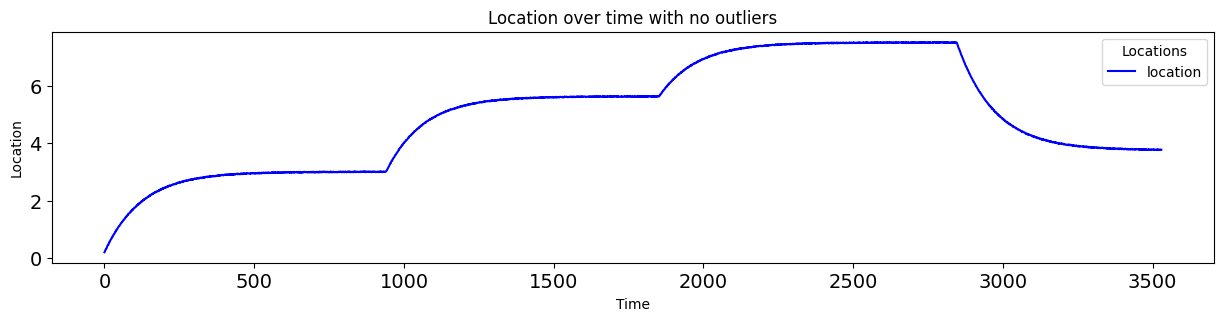

In [107]:
df.plot(color='b',figsize = (15,3))
plt.legend(loc=2)
plt.xlabel("Time")
plt.ylabel("Location")
plt.title('Location over time with no outliers')
plt.tick_params(axis='both',labelsize=14)
plt.legend(loc='upper right')
plt.legend(title="Locations")
plt.savefig(figuredir + "location-over-time-no-outliers.png", bbox_inches='tight', dpi=1200)

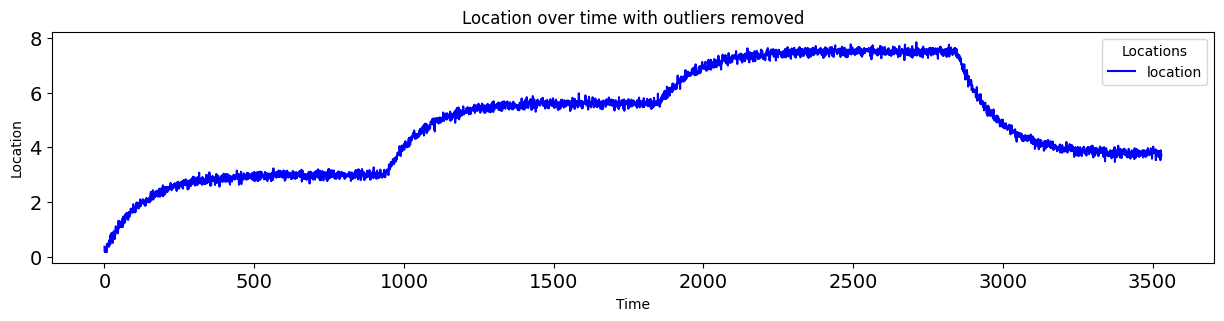

In [108]:
dfNoise.plot(color='b',figsize = (15,3))
plt.legend(loc=2)
plt.xlabel("Time")
plt.ylabel("Location")
plt.title('Location over time with outliers removed')
plt.tick_params(axis='both',labelsize=14)
plt.legend(loc='upper right')
plt.legend(title="Locations")
plt.savefig(figuredir + "location-over-time-outliers-removed.png", bbox_inches='tight', dpi=1200)

In [109]:
scaler = MinMaxScaler(feature_range=(0,1))
normalisedLocation = scaler.fit_transform(df)
normalisedLocation = pd.DataFrame(normalisedLocation, columns=['location'])
normalisedLocation


,location
0,0.000000
1,0.003065
2,0.007473
3,0.009120
4,0.013480
...,...
3525,0.489242
3526,0.486489
3527,0.487839
3528,0.487822


In [110]:
scaler = MinMaxScaler(feature_range=(0,1))
normalisedLocationNoise = scaler.fit_transform(dfNoise)
normalisedLocationNoise = pd.DataFrame(normalisedLocationNoise  , columns=['location'])
normalisedLocationNoise

,location
0,0.026256
1,0.001068
2,0.011768
3,0.018222
4,0.006781
...,...
3525,0.472458
3526,0.438357
3527,0.485221
3528,0.453775


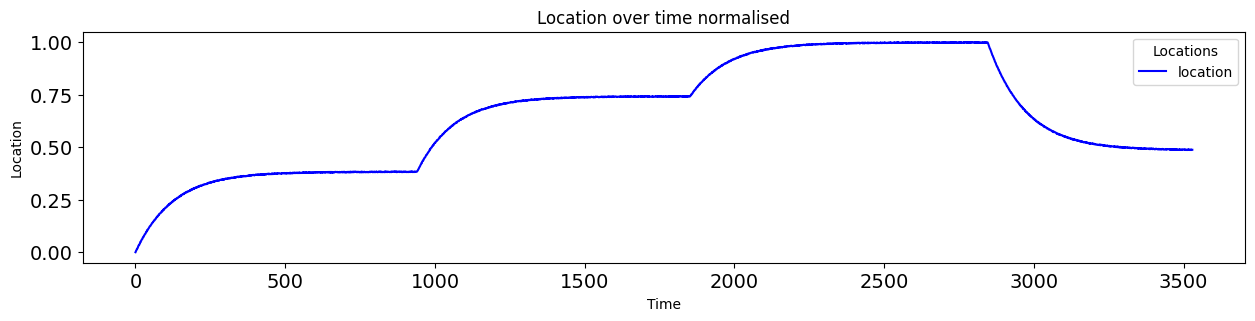

In [111]:
normalisedLocation.plot(color='b',figsize = (15, 3))
plt.legend(loc=2)
plt.xlabel("Time")
plt.ylabel("Location")
plt.title('Location over time normalised')
plt.tick_params(axis='both',labelsize=14)
plt.legend(loc='upper right')
plt.legend(title="Locations")
plt.savefig(figuredir + "location-over-time-normalised.png", bbox_inches='tight', dpi=1200)

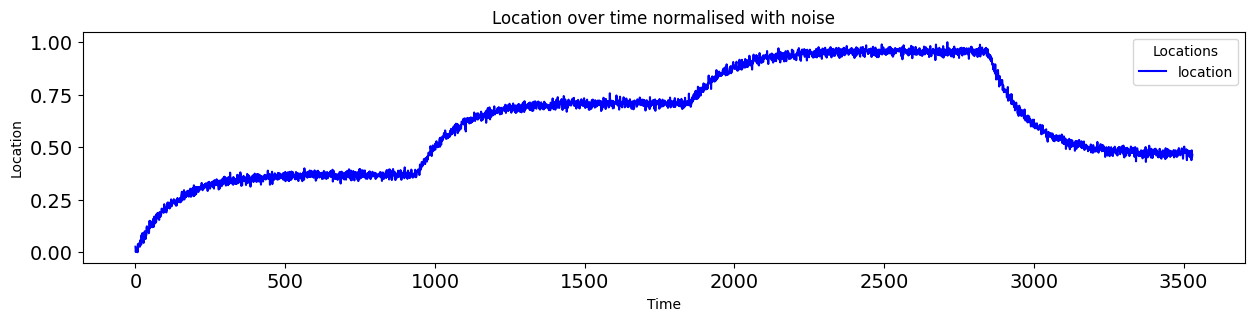

In [112]:
normalisedLocationNoise.plot(color='b',figsize = (15, 3))
plt.legend(loc=2)
plt.xlabel("Time")
plt.ylabel("Location")
plt.title('Location over time normalised with noise')
plt.tick_params(axis='both',labelsize=14)
plt.legend(loc='upper right')
plt.legend(title="Locations")
plt.savefig(figuredir + "location-over-time-normalised-with-noise.png", bbox_inches='tight', dpi=1200)

In [18]:
dataset = normalisedLocation
dataset = pd.DataFrame(dataset)
dataset.head()

,location
0,0.000000
1,0.003065
2,0.007473
3,0.009120
4,0.013480


In [19]:
def dataset_sorting(dataset, trainingSize):
    train_size = int(len(dataset) * (trainingSize/100))
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

    print("Total Dataset        = ", len(dataset))
    print("Training Sample      = ", train_size)
    print("Testing Sample       = ", test_size)

    return train, test

In [20]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset.iloc[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back])
    return np.array(dataX), np.array(dataY)

In [21]:
def look_back(train, test, lookBack):    
    trainX, trainY = create_dataset(train['location'], lookBack)
    testX, testY = create_dataset(test['location'], lookBack)
    return trainX, testX, trainY, testY

In [22]:
def reshaping(trainX, testX):
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    return trainX, testX

In [23]:
def model_configuration(trainX, trainY, neurons, epochs, batchSize, unit, lookBack):
    model = Sequential()
    # model.add(LSTM(500, input_shape=(1, look_back)))
    model.add(LSTM(unit, input_shape=(1, lookBack)))
    # model.add(Dense(150))
    # model.add(Dense(100))
    model.add(Dense(neurons))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=epochs, batch_size=batchSize, verbose=1)

    return model

In [24]:
def model_configuration2(trainX, trainY, neurons1, neurons2, epochs, batchSize, unit, lookBack):
    model = Sequential()
    # model.add(LSTM(500, input_shape=(1, look_back)))
    model.add(LSTM(unit, input_shape=(1, lookBack)))
    model.add(Dense(neurons1))
    model.add(Dense(neurons2))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=epochs, batch_size=batchSize, verbose=1)

    return model

In [25]:
def model_configuration3(trainX, trainY, neurons1, neurons2, neurons3, epochs, batchSize, unit, lookBack):
    model = Sequential()
    # model.add(LSTM(500, input_shape=(1, look_back)))
    model.add(LSTM(unit, input_shape=(1, lookBack)))
    model.add(Dense(neurons1))
    model.add(Dense(neurons2))
    model.add(Dense(neurons3))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=epochs, batch_size=batchSize, verbose=1)

    return model

In [26]:
def scores(model, trainX, testX, trainY, testY):
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

    print('Train Score: MAE',mean_absolute_error(trainY[0], trainPredict[:,0]))
    print('Test Score: MAE',mean_absolute_error(testY[0], testPredict[:,0]))

    MAEPTr = mean_absolute_percentage_error(trainY[0], trainPredict[:,0])
    MAEPTs = mean_absolute_percentage_error(testY[0], testPredict[:,0])

    print('Train Score: MARP = {}%'.format(MAEPTr))
    print('Test Score: MARP = {}%'.format(MAEPTs))

    return trainPredict, testPredict

In [27]:
def prediction(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons, unit): 
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[lookBack:len(trainPredict)+lookBack, :] = trainPredict

    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(lookBack*2)+1:len(dataset)-1, :] = testPredict

    plt.figure(figsize=(10,5))
    plt.plot(scaler.inverse_transform(dataset), label='dataset',color='blue')
    plt.plot(testPredictPlot,label='Prediction',color='orange')

    plt.legend(loc=2)
    plt.ylabel=("Time")
    plt.xlabel=("Location")
    plt.title('LSTM Forcasting after filter moving average '+str(trainingSize)+"%-"+str(batchSize)+":BSize "+str(epochs)+":Epoch "+str(neurons)+":Neurons "+str(unit)+':LSTM')
    plt.savefig(figuredir + "LSTM-Forcasting-after-filter-moving-average-"+str(trainingSize)+"%-"+str(batchSize)+"-"+str(epochs)+"-"+str(neurons)+"-"+str(unit)+".png",bbox_inches='tight', dpi=1200)
    plt.show()

In [28]:
def prediction2(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons1, neurons2, unit): 
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[lookBack:len(trainPredict)+lookBack, :] = trainPredict

    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(lookBack*2)+1:len(dataset)-1, :] = testPredict

    plt.figure(figsize=(10,5))
    plt.plot(scaler.inverse_transform(dataset), label='dataset',color='blue')
    plt.plot(testPredictPlot,label='Prediction',color='orange')

    plt.legend(loc=2)
    plt.ylabel=("Time")
    plt.xlabel=("Location")
    plt.title('LSTM Forcasting after filter moving average '+str(trainingSize)+"%-"+str(batchSize)+":BSize "+str(epochs)+":Epoch "+str(neurons1)+":Neurons1 "+str(neurons2)+":Neurons2 "+str(unit)+':LSTM')
    plt.savefig(figuredir + "LSTM-Forcasting-after-filter-moving-average-"+str(trainingSize)+"%-"+str(batchSize)+"-"+str(epochs)+"-"+str(neurons1)+"-"+str(neurons2)+"-"+str(unit)+".png",bbox_inches='tight', dpi=1200)
    plt.show()

In [29]:
def prediction3(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons1, neurons2, neurons3, unit): 
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[lookBack:len(trainPredict)+lookBack, :] = trainPredict

    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(lookBack*2)+1:len(dataset)-1, :] = testPredict

    plt.figure(figsize=(10,5))
    plt.plot(scaler.inverse_transform(dataset), label='dataset',color='blue')
    plt.plot(testPredictPlot,label='Prediction',color='orange')

    plt.legend(loc=2)
    plt.ylabel=("Time")
    plt.xlabel=("Location")
    plt.title('LSTM Forcasting after filter moving average '+str(trainingSize)+"%-"+str(batchSize)+":BSize "+str(epochs)+":Epoch "+str(neurons1)+":Neurons1 "+str(neurons2)+":Neurons2 "+str(neurons3)+":Neurons3 "+str(unit)+':LSTM')
    plt.savefig(figuredir + "LSTM-Forcasting-after-filter-moving-average-"+str(trainingSize)+"%-"+str(batchSize)+"-"+str(epochs)+"-"+str(neurons1)+"-"+str(neurons2)+"-"+str(neurons3)+"-"+str(unit)+".png",bbox_inches='tight', dpi=1200)
    plt.show()

Total Dataset        =  3530
Training Sample      =  2647
Testing Sample       =  883
Epoch 1/50


2023-05-15 04:02:10.037758: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-15 04:02:10.160137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:02:10.161154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:02:10.161869: I tensorflow/core/com

2621/2621 [==============================] - 4s 1ms/step - loss: 0.0197
Epoch 2/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0138
Epoch 3/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0123
Epoch 4/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0133
Epoch 5/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0126
Epoch 6/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0111
Epoch 7/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0110
Epoch 8/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0097
Epoch 9/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0106
Epoch 10/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0099
Epoch 11/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0095
Epoch 12/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0095
Epoch 13/50


2023-05-15 04:04:31.480590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:04:31.481972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:04:31.482761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 0s 881us/step
Train Score: MAE 0.06447687106463001
Test Score: MAE 0.054157235076192106
Train Score: MARP = 0.01364605028455076%
Test Score: MARP = 0.01027750994598749%


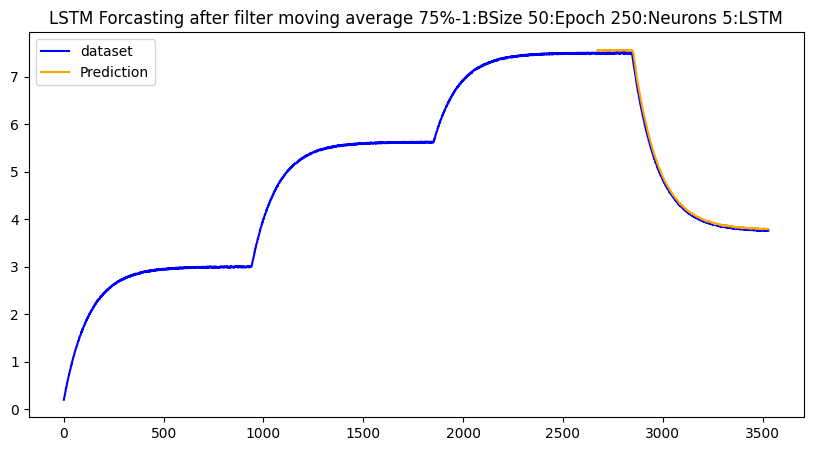

In [30]:
[train, test] = dataset_sorting(dataset, trainingSize)
[trainX, testX, trainY, testY] = look_back(train, test, lookBack)
[trainX, testX] = reshaping(trainX, testX)

[batchSize, epochs, optimizer, neurons, unit] = configure_parameters(1, 50, 'adam', 250, 5)
model = model_configuration(trainX, trainY, neurons, epochs, batchSize, unit, lookBack)
[trainPredict, testPredict] = scores(model, trainX, testX, trainY, testY)

dataset.shape

prediction(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons, unit)

Total Dataset        =  3530
Training Sample      =  2647
Testing Sample       =  883
Epoch 1/200


2023-05-15 04:04:34.088282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:04:34.089742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:04:34.090432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2621/2621 [==============================] - 4s 1ms/step - loss: 0.0202
Epoch 2/200
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0130
Epoch 3/200
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0119
Epoch 4/200
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0117
Epoch 5/200
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0097
Epoch 6/200
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0100
Epoch 7/200
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0096
Epoch 8/200
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0092
Epoch 9/200
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0088
Epoch 10/200
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0083
Epoch 11/200
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0097
Epoch 12/200
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0079
E

2023-05-15 04:14:11.119620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:14:11.121121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:14:11.121980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 0s 856us/step
Train Score: MAE 0.010555116107568973
Test Score: MAE 0.023494133900260148
Train Score: MARP = 0.0026870443225066407%
Test Score: MARP = 0.004818456634361641%


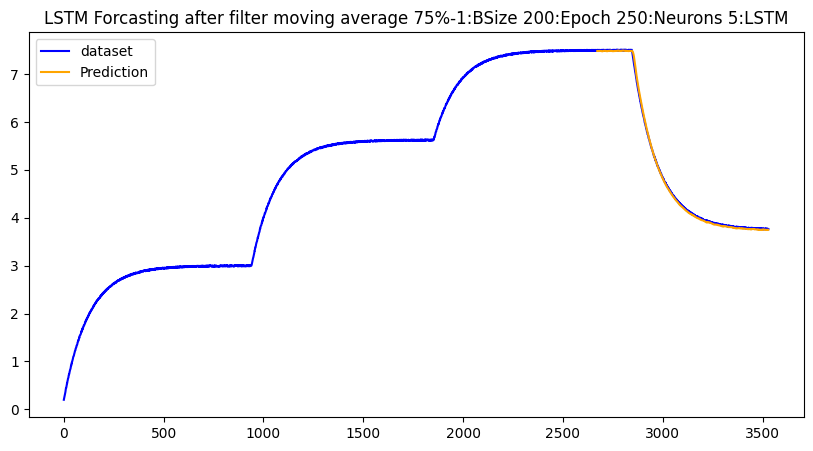

In [31]:
[train, test] = dataset_sorting(dataset, trainingSize)
[trainX, testX, trainY, testY] = look_back(train, test, lookBack)
[trainX, testX] = reshaping(trainX, testX)

[batchSize, epochs, optimizer, neurons, unit] = configure_parameters(1, 200, 'adam', 250, 5)
model = model_configuration(trainX, trainY, neurons, epochs, batchSize, unit, lookBack)
[trainPredict, testPredict] = scores(model, trainX, testX, trainY, testY)

dataset.shape

prediction(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons, unit)

Total Dataset        =  3530
Training Sample      =  2647
Testing Sample       =  883
Epoch 1/10


2023-05-15 04:14:13.895877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:14:13.897286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:14:13.897979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2621/2621 [==============================] - 4s 1ms/step - loss: 0.0223
Epoch 2/10
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0138
Epoch 3/10
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0138
Epoch 4/10
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0121
Epoch 5/10
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0120
Epoch 6/10
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0111
Epoch 7/10
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0111
Epoch 8/10
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0110
Epoch 9/10
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0102
Epoch 10/10
 1/27 [>.............................] - ETA: 0s

2023-05-15 04:14:43.386126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:14:43.387577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:14:43.388301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 0s 836us/step
Train Score: MAE 0.0433173810859957
Test Score: MAE 0.06824646595469755
Train Score: MARP = 0.009435308031371516%
Test Score: MARP = 0.01231861166424499%


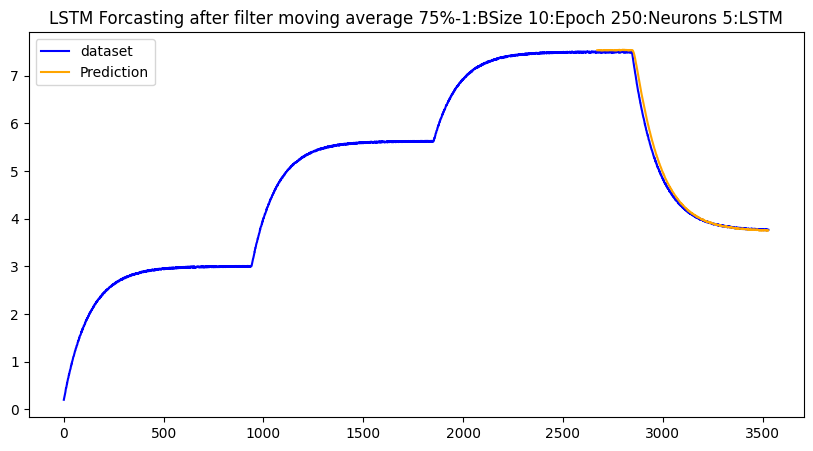

In [32]:
[train, test] = dataset_sorting(dataset, trainingSize)
[trainX, testX, trainY, testY] = look_back(train, test, lookBack)
[trainX, testX] = reshaping(trainX, testX)

[batchSize, epochs, optimizer, neurons, unit] = configure_parameters(1, 10, 'adam', 250, 5)
model = model_configuration(trainX, trainY, neurons, epochs, batchSize, unit, lookBack)
[trainPredict, testPredict] = scores(model, trainX, testX, trainY, testY)

dataset.shape

prediction(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons, unit)

Total Dataset        =  3530
Training Sample      =  2647
Testing Sample       =  883
Epoch 1/50


2023-05-15 04:14:45.855634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:14:45.857035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:14:45.857873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2621/2621 [==============================] - 4s 1ms/step - loss: 0.0202
Epoch 2/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0123
Epoch 3/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0135
Epoch 4/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0110
Epoch 5/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0117
Epoch 6/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0111
Epoch 7/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0119
Epoch 8/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0104
Epoch 9/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0089
Epoch 10/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0085
Epoch 11/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0091
Epoch 12/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0087
Epoch 13/50


2023-05-15 04:17:09.453700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:17:09.455108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:17:09.455971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 0s 922us/step
Train Score: MAE 0.018173875387091247
Test Score: MAE 0.03723560340007668
Train Score: MARP = 0.003833223480740801%
Test Score: MARP = 0.007915434461318127%


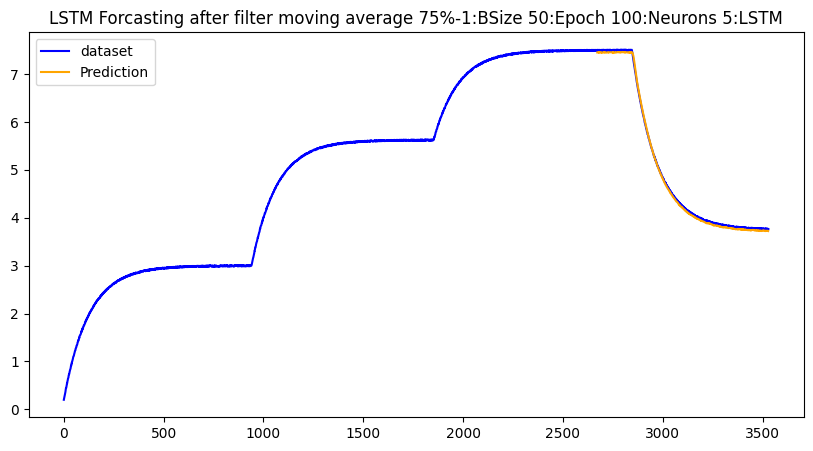

In [33]:
[train, test] = dataset_sorting(dataset, trainingSize)
[trainX, testX, trainY, testY] = look_back(train, test, lookBack)
[trainX, testX] = reshaping(trainX, testX)

[batchSize, epochs, optimizer, neurons, unit] = configure_parameters(1, 50, 'adam', 100, 5)
model = model_configuration(trainX, trainY, neurons, epochs, batchSize, unit, lookBack)
[trainPredict, testPredict] = scores(model, trainX, testX, trainY, testY)

dataset.shape

prediction(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons, unit)

Total Dataset        =  3530
Training Sample      =  2647
Testing Sample       =  883
Epoch 1/50


2023-05-15 04:17:11.927154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:17:11.928559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:17:11.929255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2621/2621 [==============================] - 4s 1ms/step - loss: 0.0182
Epoch 2/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0109
Epoch 3/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0109
Epoch 4/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0104
Epoch 5/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0108
Epoch 6/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0098
Epoch 7/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0101
Epoch 8/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0094
Epoch 9/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0091
Epoch 10/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0079
Epoch 11/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0077
Epoch 12/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0077
Epoch 13/50


2023-05-15 04:19:36.942839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:19:36.944659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:19:36.945772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 0s 882us/step
Train Score: MAE 0.05390598227091901
Test Score: MAE 0.06854090142432225
Train Score: MARP = 0.011961094745143924%
Test Score: MARP = 0.014537535839356564%


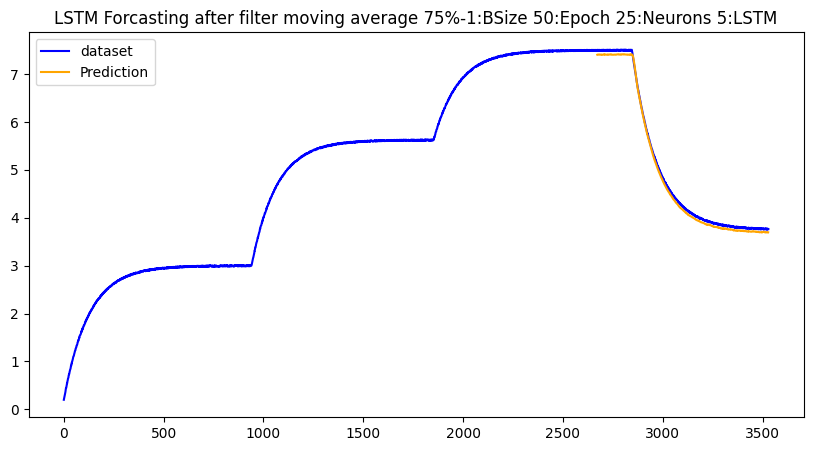

In [34]:
[train, test] = dataset_sorting(dataset, trainingSize)
[trainX, testX, trainY, testY] = look_back(train, test, lookBack)
[trainX, testX] = reshaping(trainX, testX)

[batchSize, epochs, optimizer, neurons, unit] = configure_parameters(1, 50, 'adam', 25, 5)
model = model_configuration(trainX, trainY, neurons, epochs, batchSize, unit, lookBack)
[trainPredict, testPredict] = scores(model, trainX, testX, trainY, testY)

dataset.shape

prediction(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons, unit)

Total Dataset        =  3530
Training Sample      =  2647
Testing Sample       =  883
Epoch 1/50


2023-05-15 04:19:39.616689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:19:39.618193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:19:39.619076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2621/2621 [==============================] - 4s 1ms/step - loss: 0.0150
Epoch 2/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0096
Epoch 3/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0090
Epoch 4/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0086
Epoch 5/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0079
Epoch 6/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0079
Epoch 7/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0076
Epoch 8/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0071
Epoch 9/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0074
Epoch 10/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0071
Epoch 11/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0072
Epoch 12/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0069
Epoch 13/50


2023-05-15 04:22:02.660124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:22:02.661956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:22:02.663092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 0s 831us/step
Train Score: MAE 0.017863749137893736
Test Score: MAE 0.030512193657718404
Train Score: MARP = 0.004826741470966702%
Test Score: MARP = 0.006679558690984255%


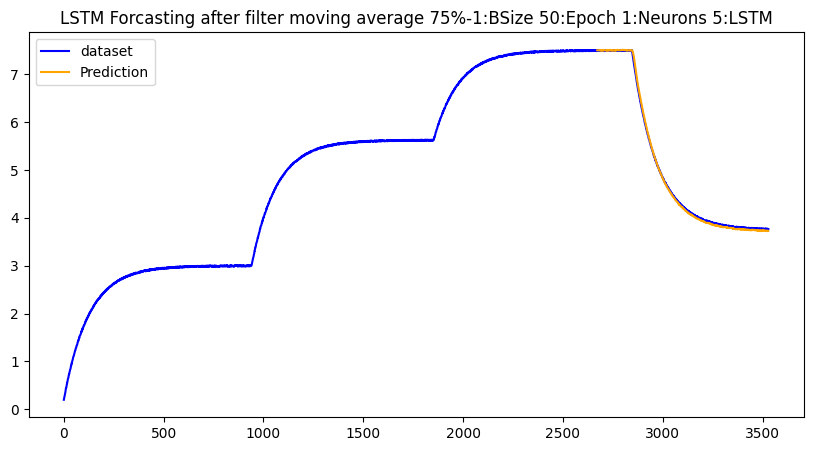

In [35]:
[train, test] = dataset_sorting(dataset, trainingSize)
[trainX, testX, trainY, testY] = look_back(train, test, lookBack)
[trainX, testX] = reshaping(trainX, testX)

[batchSize, epochs, optimizer, neurons, unit] = configure_parameters(1, 50, 'adam', 1, 5)
model = model_configuration(trainX, trainY, neurons, epochs, batchSize, unit, lookBack)
[trainPredict, testPredict] = scores(model, trainX, testX, trainY, testY)

dataset.shape

prediction(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons, unit)

Total Dataset        =  3530
Training Sample      =  2647
Testing Sample       =  883
Epoch 1/50


2023-05-15 04:22:05.119143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:22:05.120417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:22:05.121110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2621/2621 [==============================] - 4s 1ms/step - loss: 0.0205
Epoch 2/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0143
Epoch 3/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0138
Epoch 4/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0123
Epoch 5/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0117
Epoch 6/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0113
Epoch 7/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0101
Epoch 8/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0094
Epoch 9/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0103
Epoch 10/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0095
Epoch 11/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0091
Epoch 12/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0096
Epoch 13/50


2023-05-15 04:24:33.307205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:24:33.309418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:24:33.310747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 0s 913us/step
Train Score: MAE 0.02833138518568684
Test Score: MAE 0.052341031892035574
Train Score: MARP = 0.0061819600102227925%
Test Score: MARP = 0.011663054574036625%


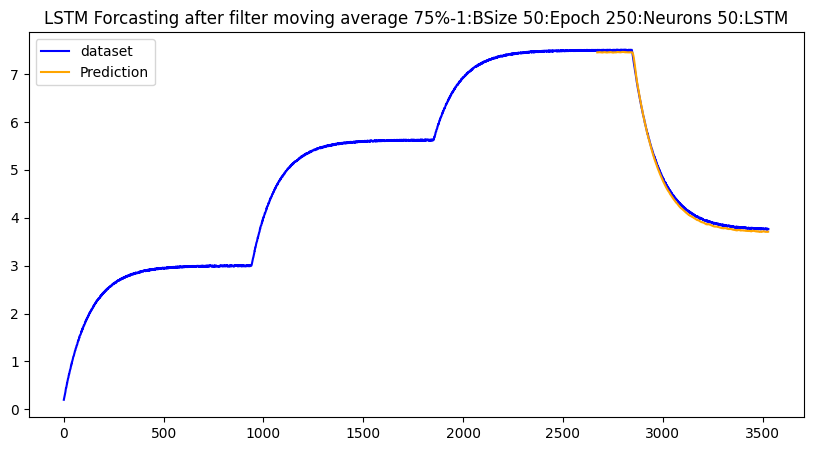

In [36]:
[train, test] = dataset_sorting(dataset, trainingSize)
[trainX, testX, trainY, testY] = look_back(train, test, lookBack)
[trainX, testX] = reshaping(trainX, testX)

[batchSize, epochs, optimizer, neurons, unit] = configure_parameters(1, 50, 'adam', 250, 50)
model = model_configuration(trainX, trainY, neurons, epochs, batchSize, unit, lookBack)
[trainPredict, testPredict] = scores(model, trainX, testX, trainY, testY)

dataset.shape

prediction(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons, unit)

Total Dataset        =  3530
Training Sample      =  2647
Testing Sample       =  883
Epoch 1/50


2023-05-15 04:24:36.074732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:24:36.076585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:24:36.077563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2621/2621 [==============================] - 4s 1ms/step - loss: 0.0231
Epoch 2/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0155
Epoch 3/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0132
Epoch 4/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0116
Epoch 5/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0117
Epoch 6/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0109
Epoch 7/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0104
Epoch 8/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0091
Epoch 9/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0098
Epoch 10/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0088
Epoch 11/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0092
Epoch 12/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0086
Epoch 13/50


2023-05-15 04:27:17.486216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:27:17.488061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:27:17.489007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 0s 928us/step
Train Score: MAE 0.03387529375811124
Test Score: MAE 0.02446050423072757
Train Score: MARP = 0.008127265353754808%
Test Score: MARP = 0.004289075273942152%


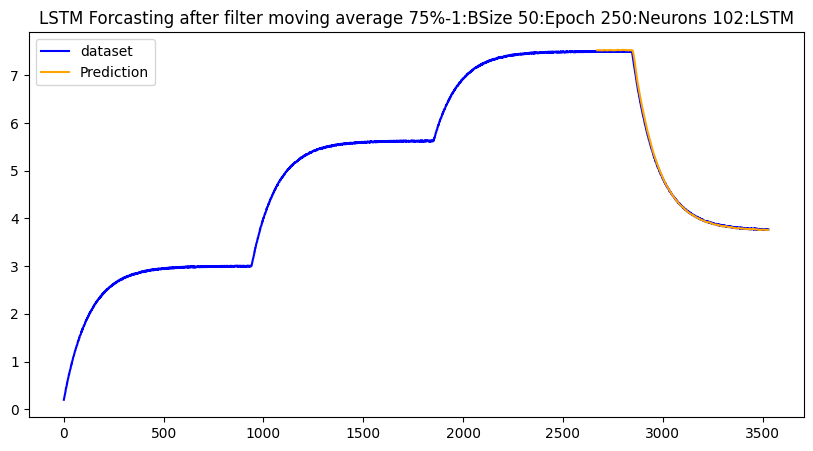

In [37]:
[train, test] = dataset_sorting(dataset, trainingSize)
[trainX, testX, trainY, testY] = look_back(train, test, lookBack)
[trainX, testX] = reshaping(trainX, testX)

[batchSize, epochs, optimizer, neurons, unit] = configure_parameters(1, 50, 'adam', 250, 102)
model = model_configuration(trainX, trainY, neurons, epochs, batchSize, unit, lookBack)
[trainPredict, testPredict] = scores(model, trainX, testX, trainY, testY)

dataset.shape
                                                                                        
prediction(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons, unit)

Total Dataset        =  3530
Training Sample      =  2647
Testing Sample       =  883
Epoch 1/50


2023-05-15 04:27:20.323096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:27:20.325008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:27:20.325978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2621/2621 [==============================] - 15s 5ms/step - loss: 0.0253
Epoch 2/50
2621/2621 [==============================] - 14s 5ms/step - loss: 0.0165
Epoch 3/50
2621/2621 [==============================] - 14s 5ms/step - loss: 0.0149
Epoch 4/50
2621/2621 [==============================] - 14s 5ms/step - loss: 0.0119
Epoch 5/50
2621/2621 [==============================] - 13s 5ms/step - loss: 0.0120
Epoch 6/50
2621/2621 [==============================] - 13s 5ms/step - loss: 0.0115
Epoch 7/50
2621/2621 [==============================] - 13s 5ms/step - loss: 0.0103
Epoch 8/50
2621/2621 [==============================] - 14s 5ms/step - loss: 0.0096
Epoch 9/50
2621/2621 [==============================] - 14s 5ms/step - loss: 0.0098
Epoch 10/50
2621/2621 [==============================] - 14s 5ms/step - loss: 0.0090
Epoch 11/50
2621/2621 [==============================] - 14s 5ms/step - loss: 0.0101
Epoch 12/50
2621/2621 [==============================] - 14s 5ms/step - loss: 0.0095


2023-05-15 04:38:35.050604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:38:35.051705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:38:35.053259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 0s 2ms/step
Train Score: MAE 0.027251798652455424
Test Score: MAE 0.03228360002942094
Train Score: MARP = 0.005732501056098244%
Test Score: MARP = 0.0061873894250933795%


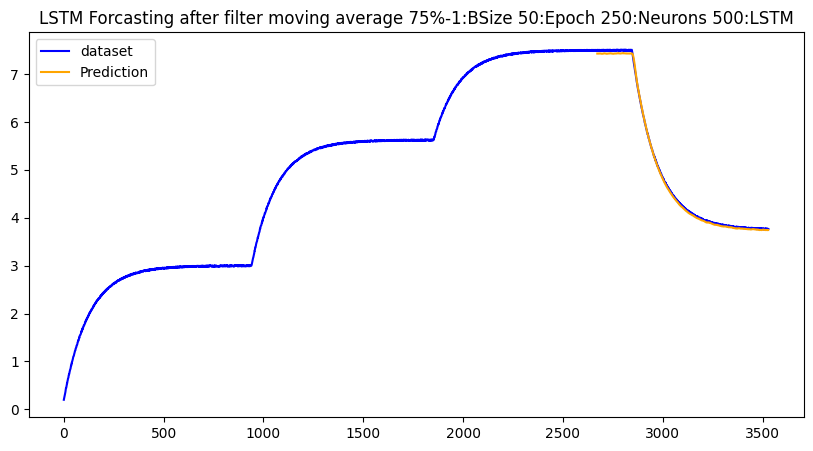

In [38]:
[train, test] = dataset_sorting(dataset, trainingSize)
[trainX, testX, trainY, testY] = look_back(train, test, lookBack)
[trainX, testX] = reshaping(trainX, testX)

[batchSize, epochs, optimizer, neurons, unit] = configure_parameters(1, 50, 'adam', 250, 500)
model = model_configuration(trainX, trainY, neurons, epochs, batchSize, unit, lookBack)
[trainPredict, testPredict] = scores(model, trainX, testX, trainY, testY)

dataset.shape
                                                                                        
prediction(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons, unit)

In [39]:
trainingSize = 40

Total Dataset        =  3530
Training Sample      =  1412
Testing Sample       =  2118
Epoch 1/50


2023-05-15 04:38:38.884720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:38:38.886196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:38:38.886959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1386/1386 [==============================] - 2s 1ms/step - loss: 0.0247
Epoch 2/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0090
Epoch 3/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0081
Epoch 4/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0079
Epoch 5/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0076
Epoch 6/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0071
Epoch 7/50
1386/1386 [==============================] - 1s 1ms/step - loss: 0.0081
Epoch 8/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0077
Epoch 9/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0072
Epoch 10/50
1386/1386 [==============================] - 1s 1ms/step - loss: 0.0070
Epoch 11/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0068
Epoch 12/50
1386/1386 [==============================] - 1s 1ms/step - loss: 0.0058
Epoch 13/50


2023-05-15 04:39:55.267731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:39:55.269414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:39:55.270492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

66/66 [==============================] - 0s 818us/step
Train Score: MAE 0.08404602758617867
Test Score: MAE 0.352533656787046
Train Score: MARP = 0.02597696948186414%
Test Score: MARP = 0.050250088316310074%


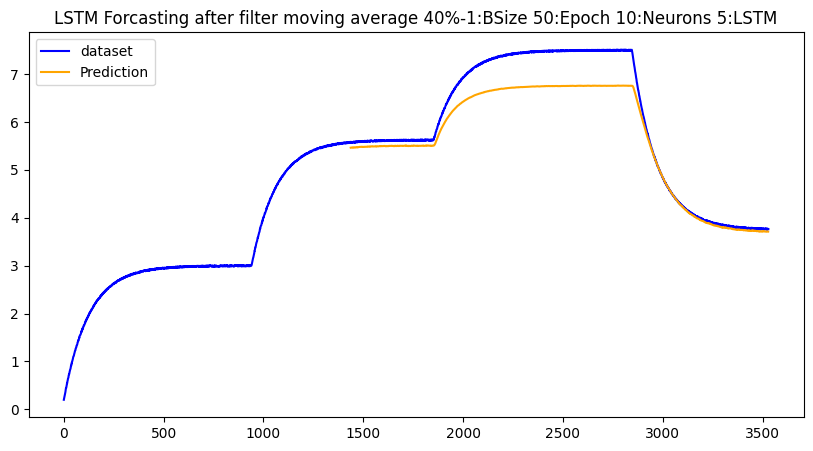

In [40]:
[train, test] = dataset_sorting(dataset, trainingSize)
[trainX, testX, trainY, testY] = look_back(train, test, lookBack)
[trainX, testX] = reshaping(trainX, testX)

[batchSize, epochs, optimizer, neurons, unit] = configure_parameters(1, 50, 'adam', 10, 5)
model = model_configuration(trainX, trainY, neurons, epochs, batchSize, unit, lookBack)
[trainPredict, testPredict] = scores(model, trainX, testX, trainY, testY)

dataset.shape
                                                                                        
prediction(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons, unit)

Total Dataset        =  3530
Training Sample      =  1412
Testing Sample       =  2118
Epoch 1/50


2023-05-15 04:39:57.947374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:39:57.948640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:39:57.949394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1386/1386 [==============================] - 2s 1ms/step - loss: 0.0174
Epoch 2/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0081
Epoch 3/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0077
Epoch 4/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0081
Epoch 5/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0067
Epoch 6/50
1386/1386 [==============================] - 1s 1ms/step - loss: 0.0069
Epoch 7/50
1386/1386 [==============================] - 1s 1ms/step - loss: 0.0068
Epoch 8/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0071
Epoch 9/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0068
Epoch 10/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0062
Epoch 11/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0064
Epoch 12/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0060
Epoch 13/50


2023-05-15 04:41:14.586603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:41:14.587996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:41:14.588803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Train Score: MAE 0.03671244918232908
Test Score: MAE 0.27707464097412415
Train Score: MARP = 0.011601453199097578%
Test Score: MARP = 0.04056688857519593%


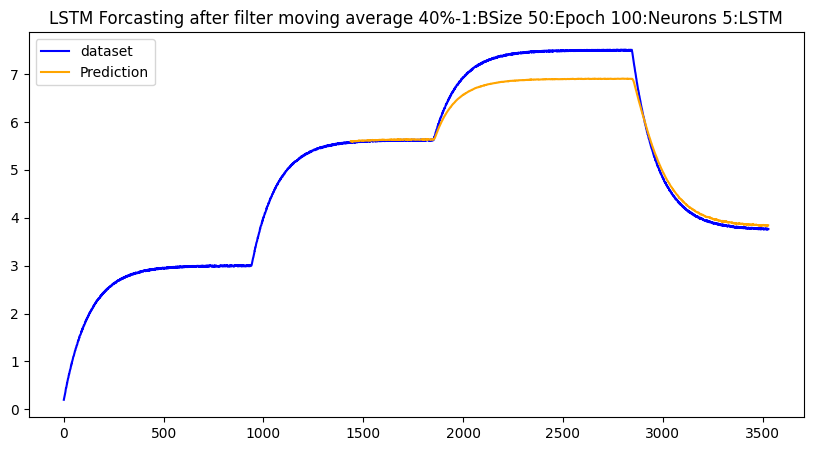

In [41]:
[train, test] = dataset_sorting(dataset, trainingSize)
[trainX, testX, trainY, testY] = look_back(train, test, lookBack)
[trainX, testX] = reshaping(trainX, testX)

[batchSize, epochs, optimizer, neurons, unit] = configure_parameters(1, 50, 'adam', 100, 5)
model = model_configuration(trainX, trainY, neurons, epochs, batchSize, unit, lookBack)
[trainPredict, testPredict] = scores(model, trainX, testX, trainY, testY)

dataset.shape
                                                                                        
prediction(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons, unit)

Total Dataset        =  3530
Training Sample      =  1412
Testing Sample       =  2118
Epoch 1/50


2023-05-15 04:41:17.064646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:41:17.066032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:41:17.066825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1386/1386 [==============================] - 2s 1ms/step - loss: 0.0202
Epoch 2/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0096
Epoch 3/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0098
Epoch 4/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0093
Epoch 5/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0083
Epoch 6/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0082
Epoch 7/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0080
Epoch 8/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0067
Epoch 9/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0067
Epoch 10/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0068
Epoch 11/50
1386/1386 [==============================] - 1s 1ms/step - loss: 0.0064
Epoch 12/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0061
Epoch 13/50


2023-05-15 04:42:33.417399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:42:33.419201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:42:33.420290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

66/66 [==============================] - 0s 829us/step
Train Score: MAE 0.0969824734288604
Test Score: MAE 0.29265528282945513
Train Score: MARP = 0.028931249690179215%
Test Score: MARP = 0.0459705854156832%


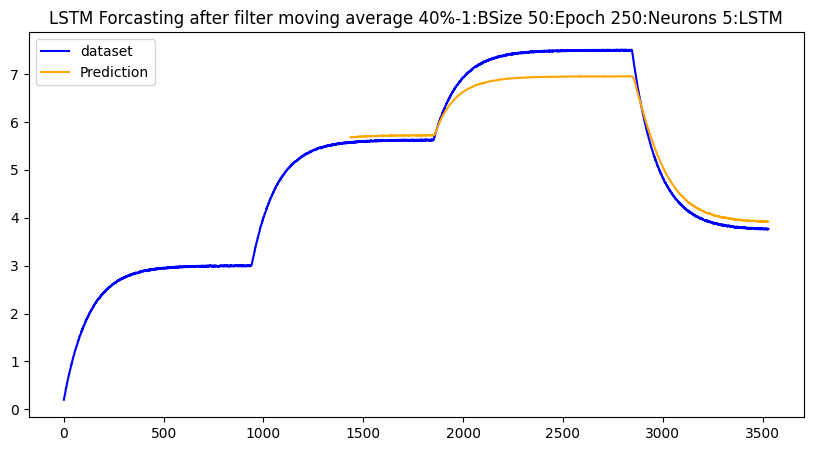

In [42]:
[train, test] = dataset_sorting(dataset, trainingSize)
[trainX, testX, trainY, testY] = look_back(train, test, lookBack)
[trainX, testX] = reshaping(trainX, testX)

[batchSize, epochs, optimizer, neurons, unit] = configure_parameters(1, 50, 'adam', 250, 5)
model = model_configuration(trainX, trainY, neurons, epochs, batchSize, unit, lookBack)
[trainPredict, testPredict] = scores(model, trainX, testX, trainY, testY)

dataset.shape
                                                                                        
prediction(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons, unit)

Total Dataset        =  3530
Training Sample      =  1412
Testing Sample       =  2118
Epoch 1/50


2023-05-15 04:42:35.929036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:42:35.930102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:42:35.931035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1386/1386 [==============================] - 8s 5ms/step - loss: 0.0228
Epoch 2/50
1386/1386 [==============================] - 7s 5ms/step - loss: 0.0148
Epoch 3/50
1386/1386 [==============================] - 7s 5ms/step - loss: 0.0117
Epoch 4/50
1386/1386 [==============================] - 7s 5ms/step - loss: 0.0110
Epoch 5/50
1386/1386 [==============================] - 7s 5ms/step - loss: 0.0091
Epoch 6/50
1386/1386 [==============================] - 7s 5ms/step - loss: 0.0087
Epoch 7/50
1386/1386 [==============================] - 7s 5ms/step - loss: 0.0087
Epoch 8/50
1386/1386 [==============================] - 7s 5ms/step - loss: 0.0080
Epoch 9/50
1386/1386 [==============================] - 7s 5ms/step - loss: 0.0074
Epoch 10/50
1386/1386 [==============================] - 7s 5ms/step - loss: 0.0077
Epoch 11/50
1386/1386 [==============================] - 7s 5ms/step - loss: 0.0073
Epoch 12/50
1386/1386 [==============================] - 7s 5ms/step - loss: 0.0071
Epoch 13/50


2023-05-15 04:48:33.605684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:48:33.607712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:48:33.608482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

66/66 [==============================] - 0s 2ms/step
Train Score: MAE 0.01575034616131065
Test Score: MAE 0.29650534019390706
Train Score: MARP = 0.005223711964456171%
Test Score: MARP = 0.04239872093906024%


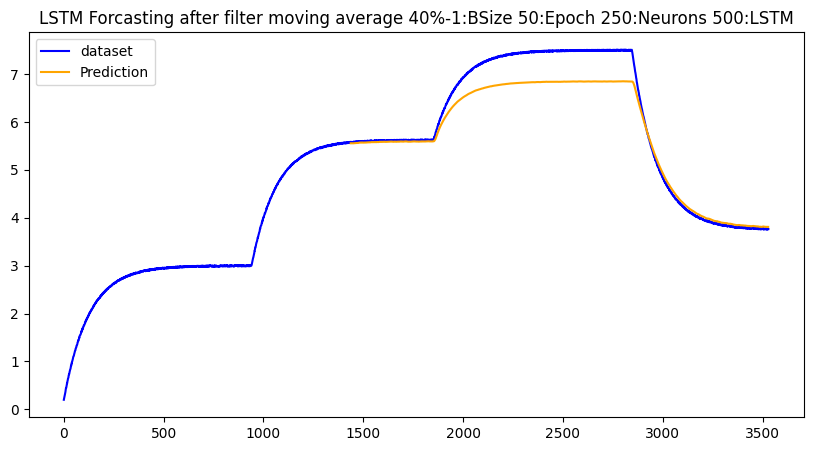

In [43]:
[train, test] = dataset_sorting(dataset, trainingSize)
[trainX, testX, trainY, testY] = look_back(train, test, lookBack)
[trainX, testX] = reshaping(trainX, testX)

[batchSize, epochs, optimizer, neurons, unit] = configure_parameters(1, 50, 'adam', 250, 500)
model = model_configuration(trainX, trainY, neurons, epochs, batchSize, unit, lookBack)
[trainPredict, testPredict] = scores(model, trainX, testX, trainY, testY)

dataset.shape
                                                                                        
prediction(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons, unit)

Total Dataset        =  3530
Training Sample      =  1412
Testing Sample       =  2118
Epoch 1/50


2023-05-15 04:48:36.364485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:48:36.365924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:48:36.366757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1386/1386 [==============================] - 2s 1ms/step - loss: 0.0191
Epoch 2/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0146
Epoch 3/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0125
Epoch 4/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0113
Epoch 5/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0096
Epoch 6/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0091
Epoch 7/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0081
Epoch 8/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0081
Epoch 9/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0068
Epoch 10/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0074
Epoch 11/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0069
Epoch 12/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0068
Epoch 13/50


2023-05-15 04:49:56.607336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:49:56.608640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:49:56.609627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

66/66 [==============================] - 0s 886us/step
Train Score: MAE 0.03136303142849792
Test Score: MAE 0.3165750812386708
Train Score: MARP = 0.009016261507917943%
Test Score: MARP = 0.04428498661115046%


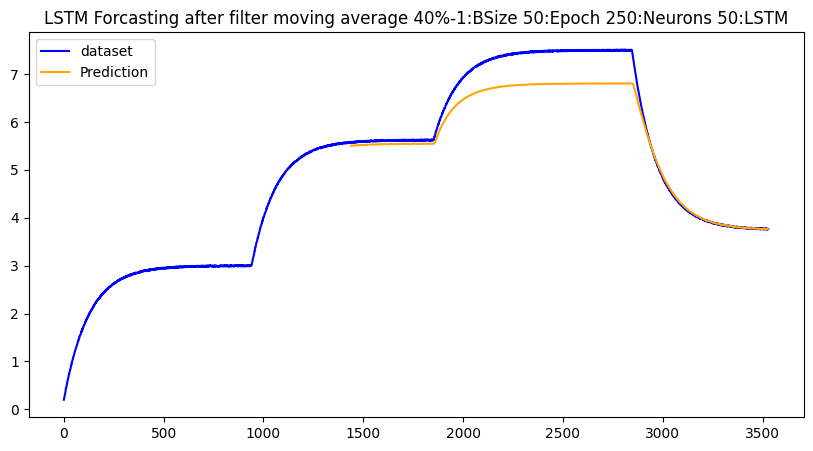

In [44]:
[train, test] = dataset_sorting(dataset, trainingSize)
[trainX, testX, trainY, testY] = look_back(train, test, lookBack)
[trainX, testX] = reshaping(trainX, testX)

[batchSize, epochs, optimizer, neurons, unit] = configure_parameters(1, 50, 'adam', 250, 50)
model = model_configuration(trainX, trainY, neurons, epochs, batchSize, unit, lookBack)
[trainPredict, testPredict] = scores(model, trainX, testX, trainY, testY)

dataset.shape
                                                                                        
prediction(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons, unit)

Total Dataset        =  3530
Training Sample      =  1412
Testing Sample       =  2118
Epoch 1/50


2023-05-15 04:49:59.090929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:49:59.092196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:49:59.093153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1386/1386 [==============================] - 2s 1ms/step - loss: 0.0192
Epoch 2/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0107
Epoch 3/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0107
Epoch 4/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0092
Epoch 5/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0095
Epoch 6/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0083
Epoch 7/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0088
Epoch 8/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0084
Epoch 9/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0081
Epoch 10/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0078
Epoch 11/50
1386/1386 [==============================] - 1s 1ms/step - loss: 0.0064
Epoch 12/50
1386/1386 [==============================] - 2s 1ms/step - loss: 0.0067
Epoch 13/50


2023-05-15 04:51:15.994937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:51:15.996356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:51:15.997044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

66/66 [==============================] - 0s 830us/step
Train Score: MAE 0.012612406254657847
Test Score: MAE 0.30633010108231096
Train Score: MARP = 0.00394376137248335%
Test Score: MARP = 0.0436582663728298%


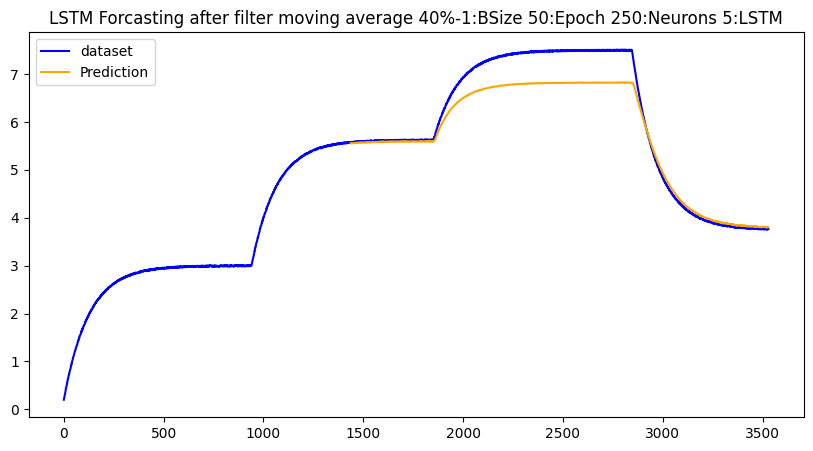

In [45]:
[train, test] = dataset_sorting(dataset, trainingSize)
[trainX, testX, trainY, testY] = look_back(train, test, lookBack)
[trainX, testX] = reshaping(trainX, testX)

[batchSize, epochs, optimizer, neurons, unit] = configure_parameters(1, 50, 'adam', 250, 5)
model = model_configuration(trainX, trainY, neurons, epochs, batchSize, unit, lookBack)
[trainPredict, testPredict] = scores(model, trainX, testX, trainY, testY)

dataset.shape
                                                                                        
prediction(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons, unit)

In [46]:
trainingSize = 75

Total Dataset        =  3530
Training Sample      =  2647
Testing Sample       =  883
Epoch 1/50


2023-05-15 04:51:18.523080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:51:18.524990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:51:18.525976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2621/2621 [==============================] - 4s 1ms/step - loss: 0.0273
Epoch 2/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0197
Epoch 3/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0165
Epoch 4/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0150
Epoch 5/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0143
Epoch 6/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0123
Epoch 7/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0135
Epoch 8/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0123
Epoch 9/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0115
Epoch 10/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0107
Epoch 11/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0102
Epoch 12/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0109
Epoch 13/50


2023-05-15 04:53:49.075475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:53:49.076737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:53:49.077598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 0s 953us/step
Train Score: MAE 0.014440339527025677
Test Score: MAE 0.0325650888598761
Train Score: MARP = 0.003663905479838701%
Test Score: MARP = 0.007032924001201293%


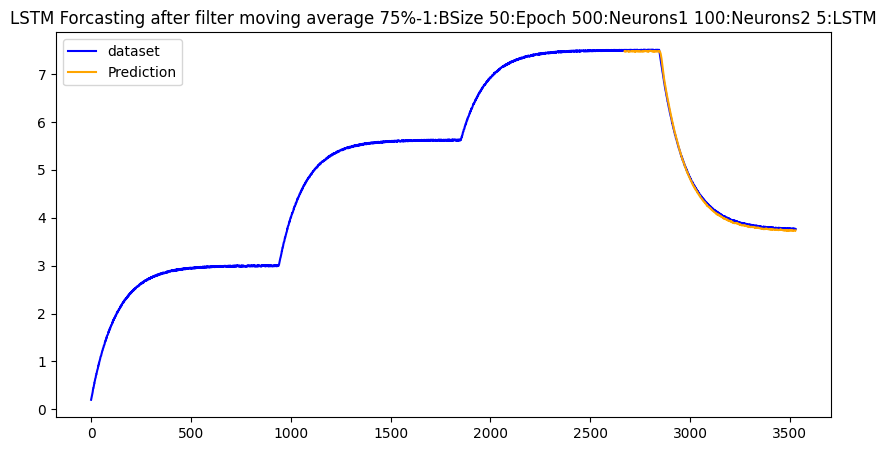

In [47]:
[train, test] = dataset_sorting(dataset, trainingSize)
[trainX, testX, trainY, testY] = look_back(train, test, lookBack)
[trainX, testX] = reshaping(trainX, testX)

[batchSize, epochs, optimizer, neurons1, neurons2, unit] = configure_parameters2(1, 50, 'adam', 500, 100, 5)
model = model_configuration2(trainX, trainY, neurons1, neurons2, epochs, batchSize, unit, lookBack)
[trainPredict, testPredict] = scores(model, trainX, testX, trainY, testY)

dataset.shape
                                                                                        
prediction2(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons1, neurons2, unit)

Total Dataset        =  3530
Training Sample      =  2647
Testing Sample       =  883
Epoch 1/50


2023-05-15 04:53:51.914934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:53:51.916285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:53:51.916979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2621/2621 [==============================] - 4s 1ms/step - loss: 0.0204
Epoch 2/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0129
Epoch 3/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0118
Epoch 4/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0117
Epoch 5/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0110
Epoch 6/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0104
Epoch 7/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0096
Epoch 8/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0099
Epoch 9/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0101
Epoch 10/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0085
Epoch 11/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0086
Epoch 12/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0087
Epoch 13/50


2023-05-15 04:56:16.905690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:56:16.907099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:56:16.908489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 0s 885us/step
Train Score: MAE 0.01980031587855548
Test Score: MAE 0.02426513936035854
Train Score: MARP = 0.004434628594961132%
Test Score: MARP = 0.004733172264879277%


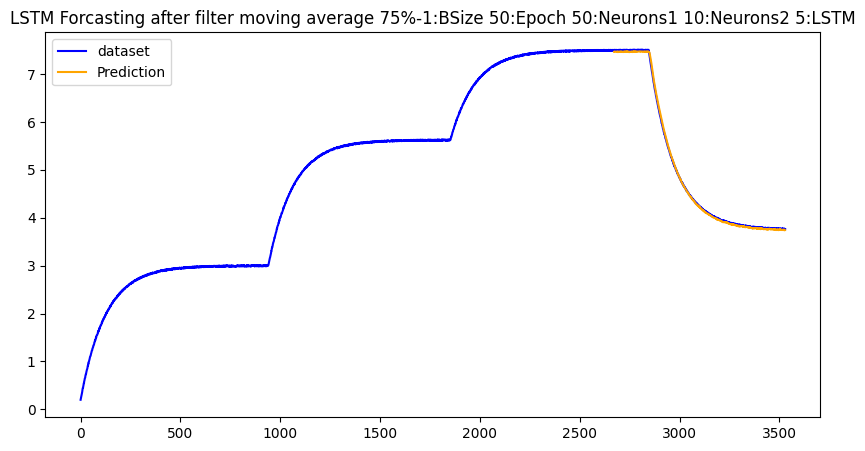

In [48]:
[train, test] = dataset_sorting(dataset, trainingSize)
[trainX, testX, trainY, testY] = look_back(train, test, lookBack)
[trainX, testX] = reshaping(trainX, testX)

[batchSize, epochs, optimizer, neurons1, neurons2, unit] = configure_parameters2(1, 50, 'adam', 50, 10, 5)
model = model_configuration2(trainX, trainY, neurons1, neurons2, epochs, batchSize, unit, lookBack)
[trainPredict, testPredict] = scores(model, trainX, testX, trainY, testY)

dataset.shape
                                                                                        
prediction2(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons1, neurons2, unit)

Total Dataset        =  3530
Training Sample      =  2647
Testing Sample       =  883
Epoch 1/50


2023-05-15 04:56:19.499300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:56:19.500575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:56:19.501482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2621/2621 [==============================] - 4s 1ms/step - loss: 0.0180
Epoch 2/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0129
Epoch 3/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0127
Epoch 4/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0120
Epoch 5/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0129
Epoch 6/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0121
Epoch 7/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0115
Epoch 8/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0112
Epoch 9/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0109
Epoch 10/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0100
Epoch 11/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0098
Epoch 12/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0091
Epoch 13/50


2023-05-15 04:58:51.577338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:58:51.579139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:58:51.580511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 0s 940us/step
Train Score: MAE 0.05227098843917151
Test Score: MAE 0.041758037423778274
Train Score: MARP = 0.009946969006780059%
Test Score: MARP = 0.006902858373683715%


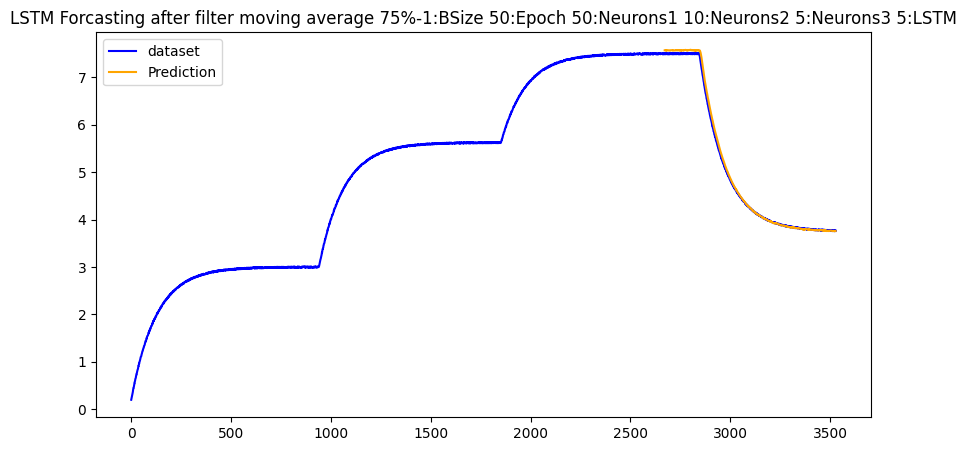

In [49]:
[train, test] = dataset_sorting(dataset, trainingSize)
[trainX, testX, trainY, testY] = look_back(train, test, lookBack)
[trainX, testX] = reshaping(trainX, testX)

[batchSize, epochs, optimizer, neurons1, neurons2, neurons3, unit] = configure_parameters3(1, 50, 'adam', 50, 10, 5, 5)
model = model_configuration3(trainX, trainY, neurons1, neurons2, neurons3, epochs, batchSize, unit, lookBack)
[trainPredict, testPredict] = scores(model, trainX, testX, trainY, testY)

dataset.shape
                                                                                        
prediction3(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons1, neurons2, neurons3, unit)

Total Dataset        =  3530
Training Sample      =  2647
Testing Sample       =  883
Epoch 1/50


2023-05-15 04:58:55.022642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 04:58:55.023886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 04:58:55.024656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2621/2621 [==============================] - 4s 1ms/step - loss: 0.0296
Epoch 2/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0205
Epoch 3/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0189
Epoch 4/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0158
Epoch 5/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0143
Epoch 6/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0141
Epoch 7/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0145
Epoch 8/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0130
Epoch 9/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0124
Epoch 10/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0127
Epoch 11/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0113
Epoch 12/50
2621/2621 [==============================] - 3s 1ms/step - loss: 0.0104
Epoch 13/50


2023-05-15 05:01:41.698679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 05:01:41.700187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 05:01:41.701118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 0s 1ms/step
Train Score: MAE 0.03424209431431919
Test Score: MAE 0.05152260864494561
Train Score: MARP = 0.006489401646066012%
Test Score: MARP = 0.010688555322881717%


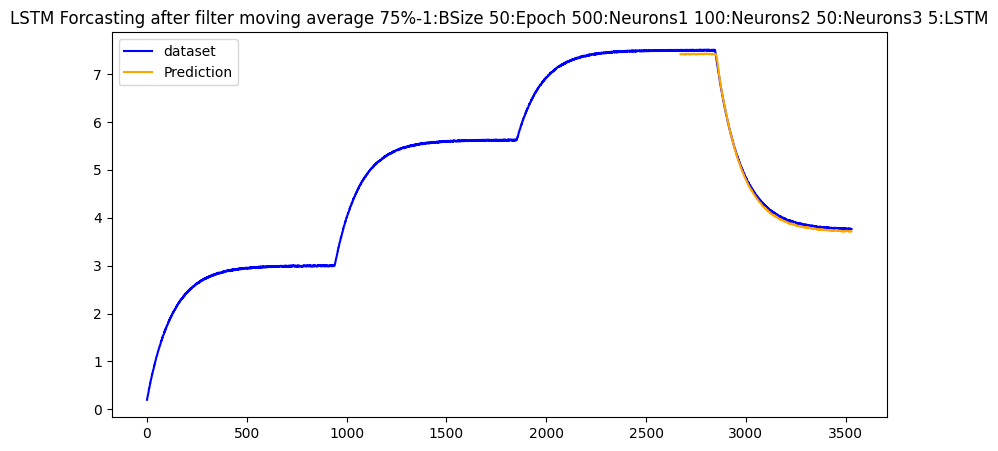

In [50]:
[train, test] = dataset_sorting(dataset, trainingSize)
[trainX, testX, trainY, testY] = look_back(train, test, lookBack)
[trainX, testX] = reshaping(trainX, testX)

[batchSize, epochs, optimizer, neurons1, neurons2, neurons3, unit] = configure_parameters3(1, 50, 'adam', 500, 100, 50, 5)
model = model_configuration3(trainX, trainY, neurons1, neurons2, neurons3, epochs, batchSize, unit, lookBack)
[trainPredict, testPredict] = scores(model, trainX, testX, trainY, testY)

dataset.shape
                                                                                        
prediction3(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons1, neurons2, neurons3, unit)

Total Dataset        =  3530
Training Sample      =  2647
Testing Sample       =  883
Epoch 1/50


2023-05-15 05:01:44.878597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 05:01:44.880623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 05:01:44.881902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

263/263 [==============================] - 1s 2ms/step - loss: 0.0392
Epoch 2/50
263/263 [==============================] - 0s 1ms/step - loss: 0.0064
Epoch 3/50
263/263 [==============================] - 0s 1ms/step - loss: 0.0062
Epoch 4/50
263/263 [==============================] - 0s 1ms/step - loss: 0.0071
Epoch 5/50
263/263 [==============================] - 0s 1ms/step - loss: 0.0067
Epoch 6/50
263/263 [==============================] - 0s 1ms/step - loss: 0.0058
Epoch 7/50
263/263 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 8/50
263/263 [==============================] - 0s 1ms/step - loss: 0.0064
Epoch 9/50
263/263 [==============================] - 0s 1ms/step - loss: 0.0051
Epoch 10/50
263/263 [==============================] - 0s 1ms/step - loss: 0.0051
Epoch 11/50
263/263 [==============================] - 0s 1ms/step - loss: 0.0068
Epoch 12/50
263/263 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 13/50
263/263 [===============

2023-05-15 05:02:04.096553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 05:02:04.098090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 05:02:04.098995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 0s 915us/step
Train Score: MAE 0.02584442072568556
Test Score: MAE 0.030334947793670117
Train Score: MARP = 0.00535104572253305%
Test Score: MARP = 0.006143699796441611%


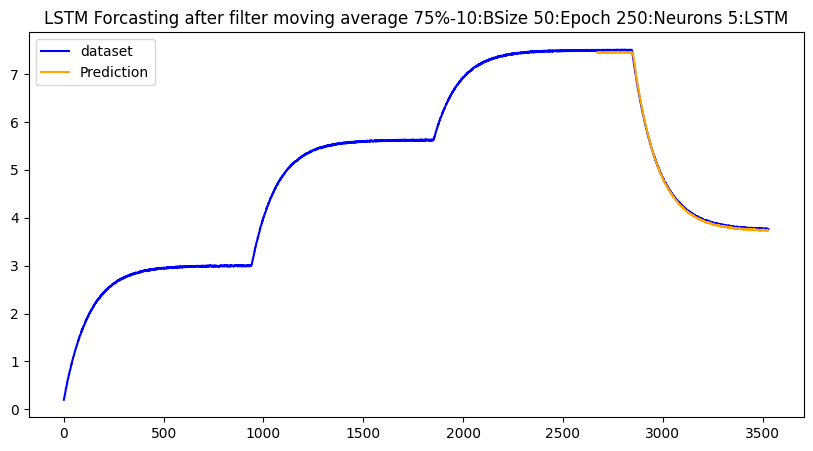

In [51]:
[train, test] = dataset_sorting(dataset, trainingSize)
[trainX, testX, trainY, testY] = look_back(train, test, lookBack)
[trainX, testX] = reshaping(trainX, testX)

[batchSize, epochs, optimizer, neurons, unit] = configure_parameters(10, 50, 'adam', 250, 5)
model = model_configuration(trainX, trainY, neurons, epochs, batchSize, unit, lookBack)
[trainPredict, testPredict] = scores(model, trainX, testX, trainY, testY)

dataset.shape
                                                                                        
prediction(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons, unit)

Total Dataset        =  3530
Training Sample      =  2647
Testing Sample       =  883
Epoch 1/50


2023-05-15 05:02:06.658727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 05:02:06.660197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 05:02:06.660998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

53/53 [==============================] - 1s 2ms/step - loss: 0.2036
Epoch 2/50
53/53 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 3/50
53/53 [==============================] - 0s 1ms/step - loss: 0.0049
Epoch 4/50
53/53 [==============================] - 0s 1ms/step - loss: 0.0062
Epoch 5/50
53/53 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 6/50
53/53 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 7/50
53/53 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 8/50
53/53 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 9/50
53/53 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 10/50
53/53 [==============================] - 0s 1ms/step - loss: 0.0044
Epoch 11/50
53/53 [==============================] - 0s 1ms/step - loss: 0.0041
Epoch 12/50
53/53 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 13/50
53/53 [==============================] - 0s 1ms/

2023-05-15 05:02:11.710124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 05:02:11.711755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 05:02:11.712718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 0s 904us/step
Train Score: MAE 0.03835082726859864
Test Score: MAE 0.049313764701959
Train Score: MARP = 0.009707670852301392%
Test Score: MARP = 0.00973928031427498%


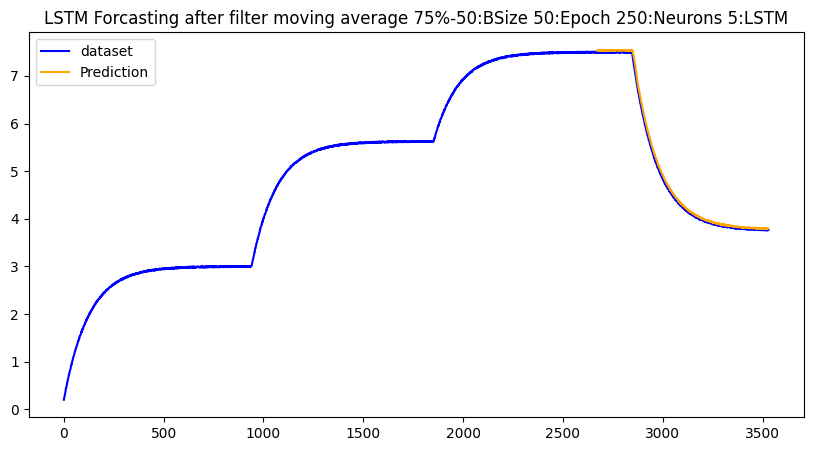

In [52]:
[train, test] = dataset_sorting(dataset, trainingSize)
[trainX, testX, trainY, testY] = look_back(train, test, lookBack)
[trainX, testX] = reshaping(trainX, testX)

[batchSize, epochs, optimizer, neurons, unit] = configure_parameters(50, 50, 'adam', 250, 5)
model = model_configuration(trainX, trainY, neurons, epochs, batchSize, unit, lookBack)
[trainPredict, testPredict] = scores(model, trainX, testX, trainY, testY)

dataset.shape
                                                                                        
prediction(trainPredict, testPredict, trainingSize, batchSize, epochs, neurons, unit)